In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
columns = ['datetime','choke','psig','apsig','oil','gas','water']
columns2 = ['choke','psig','apsig','oil','gas','water']

In [3]:
df_raw = pd.read_csv('final.csv')

# use 100 data only
# df_raw = df_raw.head(100)

df_raw = df_raw.set_index('datetime')

In [4]:
df_raw

,choke,psig,apsig,oil,gas,water
datetime,,,,,,
15/5/2021 21:00:00,38,935,320,698.880,4.980,23.616
15/5/2021 21:15:00,38,935,321,822.456,4.988,32.592
15/5/2021 21:30:00,38,940,318,661.368,5.070,26.208
15/5/2021 21:45:00,38,938,317,737.664,5.061,29.232
15/5/2021 22:00:00,38,940,319,661.368,5.078,26.208
...,...,...,...,...,...,...
4/6/2021 08:00:00,42,986,328,771.720,7.638,16.896
4/6/2021 08:15:00,42,984,325,766.032,7.602,16.704
4/6/2021 08:30:00,42,986,328,765.216,7.638,16.704


# normalization min max

In [5]:
# get choke 38 only
df_choke_38 = df_raw[df_raw['choke'] == 38].copy()
df_choke_38.shape

(854, 6)

In [6]:
def normalize_dataframe(df):
    # Create a copy of the input DataFrame to avoid modifying the original
    df_normalized = df.copy()
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column is not a datetime column
        if column != 'datetime':
            # Find the minimum and maximum values in the column
            min_value = df[column].min()
            max_value = df[column].max()
            # Normalize the column values using min-max scaling
            df_normalized[column] = (df[column] - min_value) / (max_value - min_value)
    return df_normalized

def denormalize_dataframe(df_normalized, df_original):
    # Create a copy of the normalized DataFrame to avoid modifying the original
    df_denormalized = df_normalized.copy()
    # Iterate over each column in the DataFrame
    for column in df_normalized.columns:
        # Check if the column is not a datetime column
        if column != 'datetime':
            # Find the minimum and maximum values in the original column
            min_value = df_original[column].min()
            max_value = df_original[column].max()
            # Denormalize the column values using min-max scaling
            df_denormalized[column] = df_normalized[column] * (max_value - min_value) + min_value
    return df_denormalized

In [7]:
# scaler = MinMaxScaler()
# df_choke_38 = df_choke_38.drop(['choke'], axis=1)
# df_choke_38_normalized = scaler.fit_transform(df_choke_38)
# df_choke_38_normalized = pd.DataFrame(df_choke_38_normalized, columns=df_choke_38.columns)
# df_choke_38_normalized['datetime'] = df_choke_38.index
# df_choke_38_normalized = df_choke_38_normalized.set_index('datetime')

df_choke_38 = df_choke_38.drop(['choke'], axis=1)
# df_choke_38_normalized
df_choke_38_normalized = normalize_dataframe(df_choke_38)
df_choke_38_normalized

,psig,apsig,oil,gas,water
datetime,,,,,
15/5/2021 21:00:00,0.431034,0.444444,0.311858,0.128135,0.417431
15/5/2021 21:15:00,0.431034,0.472222,0.748918,0.132497,0.631881
15/5/2021 21:30:00,0.452586,0.388889,0.179187,0.177208,0.479358
15/5/2021 21:45:00,0.443966,0.361111,0.449028,0.172301,0.551606
15/5/2021 22:00:00,0.452586,0.416667,0.179187,0.181570,0.479358
...,...,...,...,...,...
24/5/2021 16:00:00,0.978448,0.833333,0.341397,0.982007,0.220183
24/5/2021 16:15:00,0.987069,0.722222,0.432816,0.966739,0.041284
24/5/2021 16:30:00,0.965517,0.777778,0.464392,0.978190,0.043578


# LSTM Preparation

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_choke_38_normalized.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
# reframed.drop(reframed.columns[[5,6,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.431034   0.444444   0.311858   0.128135   0.417431  0.431034  0.472222   
2   0.431034   0.472222   0.748918   0.132497   0.631881  0.452586  0.388889   
3   0.452586   0.388889   0.179187   0.177208   0.479358  0.443966  0.361111   
4   0.443966   0.361111   0.449028   0.172301   0.551606  0.452586  0.416667   
5   0.452586   0.416667   0.179187   0.181570   0.479358  0.461207  0.416667   

    var3(t)   var4(t)   var5(t)  
1  0.748918  0.132497  0.631881  
2  0.179187  0.177208  0.479358  
3  0.449028  0.172301  0.551606  
4  0.179187  0.181570  0.479358  
5  0.359138  0.181570  0.527523  


# Split Data

In [10]:
train_X = reframed.iloc[:int(len(df_choke_38)*0.8), 0:5].values
test_X = reframed.iloc[int(len(df_choke_38)*0.8):, 0:5].values

train_y = reframed.iloc[:int(len(df_choke_38)*0.8), 5:10].values
test_y = reframed.iloc[int(len(df_choke_38)*0.8):, 5:10].values

print(train_y)

[[0.43103448 0.4722222  0.74891776 0.13249728 0.63188076]
 [0.4525862  0.3888889  0.17918682 0.17720829 0.4793578 ]
 [0.44396552 0.3611111  0.4490281  0.17230098 0.5516055 ]
 ...
 [0.9439655  0.6388889  0.49605298 0.8876772  0.04587156]
 [0.9396552  0.6388889  0.3934301  0.90348965 0.0946101 ]
 [0.9439655  0.6944444  0.45115015 0.91439474 0.13876146]]


# LSTM Model

In [11]:
# # sigmoid
# def sigmoid(x):
#     return 1 / (1 + math.exp(-x))
# # sigmoid derivative
# def sigmoid_derivative(x):
#     return x * (1 - x)
# # tanh
# def tanh(x):
#     return math.tanh(x)
# # tanh derivative
# def tanh_derivative(x):
#     return 1.0 - x**2

In [12]:
# # create simple LSTM cell no function and class
# def simple_lstm_cell(inputs, h, c, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
#     """
#     Implements a simple LSTM cell.

#     Args:
#         inputs (ndarray): Input array of shape (batch_size, input_size).
#         h (ndarray): Hidden state array of shape (batch_size, hidden_size).
#         c (ndarray): Cell state array of shape (batch_size, hidden_size).
#         Wf (ndarray): Weight matrix for the forget gate of shape (input_size, hidden_size).
#         Wi (ndarray): Weight matrix for the input gate of shape (input_size, hidden_size).
#         Wc (ndarray): Weight matrix for the cell state of shape (input_size, hidden_size).
#         Wo (ndarray): Weight matrix for the output gate of shape (input_size, hidden_size).
#         bf (ndarray): Bias vector for the forget gate of shape (hidden_size,).
#         bi (ndarray): Bias vector for the input gate of shape (hidden_size,).
#         bc (ndarray): Bias vector for the cell state of shape (hidden_size,).
#         bo (ndarray): Bias vector for the output gate of shape (hidden_size,).

#     Returns:
#         tuple: A tuple containing the updated hidden state (h) and cell state (c) arrays.
#     """

#     f = sigmoid(np.dot(inputs, Wf) + np.dot(h, bf))
#     i = sigmoid(np.dot(inputs, Wi) + np.dot(h, bi))
#     c_tilda = tanh(np.dot(inputs, Wc) + np.dot(h, bc))
#     c = f * c + i * c_tilda
#     o = sigmoid(np.dot(inputs, Wo) + np.dot(h, bo))
#     h = o * tanh(c)
#     return h, c, o

In [13]:
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases for the LSTM cell
        # self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bf = np.random.randn(hidden_size, 1)
        self.Wf = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bf = np.zeros((hidden_size, 1))

        # self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bi = np.random.randn(hidden_size, 1)
        self.Wi = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bi = np.zeros((hidden_size, 1))

        # self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bc = np.random.randn(hidden_size, 1)
        self.Wc = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bc = np.zeros((hidden_size, 1))

        # self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        # self.bo = np.random.randn(hidden_size, 1)
        self.Wo = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bo = np.zeros((hidden_size, 1))

        # Initialize weights for the output layer
        self.Wy = np.random.randn(output_size, hidden_size)
        self.by = np.random.randn(output_size, 1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, x, h_prev, C_prev):
      assert h_prev.shape == (self.hidden_size, 1)
      assert x.shape == (self.input_size, 1)
      assert C_prev.shape == (self.hidden_size, 1)

      # Concatenate hidden state and input
      combined = np.concatenate((h_prev, x), axis=0)

      # Forget gate
      ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)

      # Input gate
      it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
      Ct_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)

      # Cell state
      Ct = ft * C_prev + it * Ct_hat

      # Output gate
      ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
      ht = ot * self.tanh(Ct)

      # Compute output
      yt = np.dot(self.Wy, ht) + self.by

      assert yt.shape == (self.output_size, 1)
      assert ht.shape == (self.hidden_size, 1)
      assert Ct.shape == (self.hidden_size, 1)

      return yt, ht, Ct

    def train(self, X, Y, epochs=1000, learning_rate=0.001):
        m, n_x = X.shape
        n_y, _ = Y.shape

        # Initialize hidden state and cell state
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        for epoch in range(epochs):
            loss = 0
            for t in range(m):
                x = X[t].reshape(-1, 1)
                y_true = Y[t].reshape(-1, 1)

                # Forward pass
                y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)
                self.h_prev = h_prev
                self.C_prev = C_prev

                ## Compute gradients
                dy = y_pred - y_true

                # Compute gradients for output layer
                dWy = np.dot(dy, h_prev.T)
                dby = dy

                # Compute gradients for LSTM cell
                dh = np.dot(self.Wy.T, dy)
                dC = dh * self.tanh(C_prev) * (1 - self.tanh(C_prev))

                # Compute gradients for output gate
                do = dh * self.tanh(C_prev)
                dWo = np.dot(do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo)), np.concatenate((h_prev, x), axis=0).T)
                dbo = do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo))

                # Compute gradients for cell gate
                dC_bar = dC * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)
                dWc = np.dot(dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2), np.concatenate((h_prev, x), axis=0).T)
                dbc = dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2)

                # Compute gradients for input gate
                di = dC * self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc)
                dWi = np.dot(di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)), np.concatenate((h_prev, x), axis=0).T)
                dbi = di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi))

                # Compute gradients for forget gate
                df = dC * C_prev
                dWf = np.dot(df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf)), np.concatenate((h_prev, x), axis=0).T)
                dbf = df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf))

                # Update weights and biases
                self.Wy -= learning_rate * dWy
                self.by -= learning_rate * dby
                self.Wo -= learning_rate * dWo
                self.bo -= learning_rate * dbo
                self.Wc -= learning_rate * dWc
                self.bc -= learning_rate * dbc
                self.Wi -= learning_rate * dWi
                self.bi -= learning_rate * dbi
                self.Wf -= learning_rate * dWf
                self.bf -= learning_rate * dbf

                # Compute loss (mean squared error)
                loss += np.sum((y_true - y_pred) ** 2) / 2

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss / m}')

    def predict(self, X):
        m, n_x = X.shape
        predictions = np.zeros((m, self.output_size))

        # Initialize hidden state and cell state
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        for t in range(m):
            x = X[t].reshape(-1, 1)

            # Forward pass
            y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)

            # Store prediction
            predictions[t] = y_pred.flatten()

        return predictions

    def evaluate(self, X, Y):
        predictions = self.predict(X)
        mse = np.mean((Y - predictions) ** 2)
        rmse = np.sqrt(mse)
        return mse, rmse

In [14]:
# # Example usage
# np.random.seed(0)
# X = np.random.rand(100, 5)
# Y = np.random.rand(100, 5)

lstm = LSTM(input_size=5, hidden_size=100, output_size=5)
lstm.train(train_X, train_y, epochs=1000)

Epoch 1/1000, Loss: 2.1298216705567006
Epoch 2/1000, Loss: 1.1677121331379894
Epoch 3/1000, Loss: 0.669884493435226
Epoch 4/1000, Loss: 0.41180674497997
Epoch 5/1000, Loss: 0.15981676646180526
Epoch 6/1000, Loss: 0.3072607759347113
Epoch 7/1000, Loss: 0.07326208029168044
Epoch 8/1000, Loss: 0.23056337755841763
Epoch 9/1000, Loss: 0.45617625011004026
Epoch 10/1000, Loss: 0.07267055347389625
Epoch 11/1000, Loss: 0.13004427624069198
Epoch 12/1000, Loss: 0.05458889731024056
Epoch 13/1000, Loss: 0.0547746887621272
Epoch 14/1000, Loss: 0.057497765476073465
Epoch 15/1000, Loss: 0.1527693373086515
Epoch 16/1000, Loss: 0.04516689626717871
Epoch 17/1000, Loss: 0.04197887080048225
Epoch 18/1000, Loss: 0.03871934556882073
Epoch 19/1000, Loss: 0.03684566184196346
Epoch 20/1000, Loss: 0.039267899251974936
Epoch 21/1000, Loss: 0.03466559139325765
Epoch 22/1000, Loss: 0.0333694722799519
Epoch 23/1000, Loss: 0.031025828022490366
Epoch 24/1000, Loss: 0.029843809352618662
Epoch 25/1000, Loss: 0.029003285

In [15]:
predictions = lstm.predict(test_X)
print(predictions)

mse, rmse = lstm.evaluate(test_X, test_y)
print(f'MSE: {mse}, RMSE: {rmse}')

[[0.93584866 0.71142387 0.45272806 0.91339355 0.14863245]
 [0.94156035 0.71340965 0.44266365 0.91546425 0.12799936]
 [0.94031703 0.71291916 0.43879778 0.91709869 0.10439298]
 [0.94379571 0.70099081 0.45895123 0.91702601 0.08602755]
 [0.95012876 0.7030347  0.48147471 0.92078539 0.07505544]
 [0.94903466 0.71067571 0.46471325 0.91403365 0.08251634]
 [0.94277259 0.71105496 0.46935412 0.91159629 0.09034465]
 [0.94288469 0.67878668 0.42713057 0.91229058 0.09231882]
 [0.93473521 0.68062181 0.41902872 0.91917575 0.10178428]
 [0.93406593 0.7408731  0.4346736  0.91969112 0.14814171]
 [0.9365384  0.74258895 0.42135519 0.92375708 0.20724425]
 [0.93585591 0.71410345 0.42925701 0.92096863 0.21136068]
 [0.93654768 0.71578994 0.47634237 0.91993529 0.21356128]
 [0.93989105 0.69978402 0.46677579 0.92437751 0.19847983]
 [0.94035943 0.70036834 0.49337558 0.92192357 0.19164595]
 [0.95433504 0.71606849 0.47735241 0.92334861 0.14070851]
 [0.94334199 0.71976612 0.43542586 0.95062734 0.12816122]
 [0.93650809 0

In [16]:
train_X[:,:2]

array([[0.43103448, 0.44444445],
       [0.43103448, 0.4722222 ],
       [0.4525862 , 0.3888889 ],
       ...,
       [0.94827586, 0.6388889 ],
       [0.9439655 , 0.6388889 ],
       [0.9396552 , 0.6388889 ]], dtype=float32)

In [17]:
# denormalize
# predictions = scaler.inverse_transform(predictions)
# test_y = scaler.inverse_transform(test_y)

predictions = denormalize_dataframe(pd.DataFrame(predictions, columns=df_choke_38.columns), df_choke_38)
test_y = denormalize_dataframe(pd.DataFrame(test_y, columns=df_choke_38.columns), df_choke_38)
train_X = denormalize_dataframe(pd.DataFrame(train_X, columns=df_choke_38.columns), df_choke_38)

print(predictions)
print(test_y)
print(train_X)

            psig       apsig         oil       gas      water
0    1052.116889  329.611259  738.710143  6.420164  12.365160
1    1053.442001  329.682747  735.864491  6.423961  11.501541
2    1053.153552  329.665090  734.771441  6.426959  10.513472
3    1053.960606  329.235669  740.469707  6.426826   9.744769
4    1055.429873  329.309249  746.838086  6.433720   9.285520
..           ...         ...         ...       ...        ...
165  1057.173498  332.103954  721.051526  6.536202  15.245096
166  1058.652500  332.638948  718.372562  6.535270  15.384111
167  1064.095293  330.823475  725.796719  6.523440  11.142341
168  1058.037549  331.653879  732.208774  6.537939  10.620291
169  1055.408713  333.676406  727.440432  6.564190  14.850946

[170 rows x 5 columns]
       psig  apsig         oil    gas      water
0    1054.0  329.0  731.591980  6.422   9.455999
1    1053.0  329.0  733.079956  6.422   7.872000
2    1053.0  328.0  751.703979  6.412   7.248000
3    1055.0  328.0  761.423950  6.41

In [18]:
print(list(range(0, train_X.shape[0])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [19]:
print(list(range(train_X.shape[0], train_X.shape[0] + predictions.shape[0])))

[683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852]


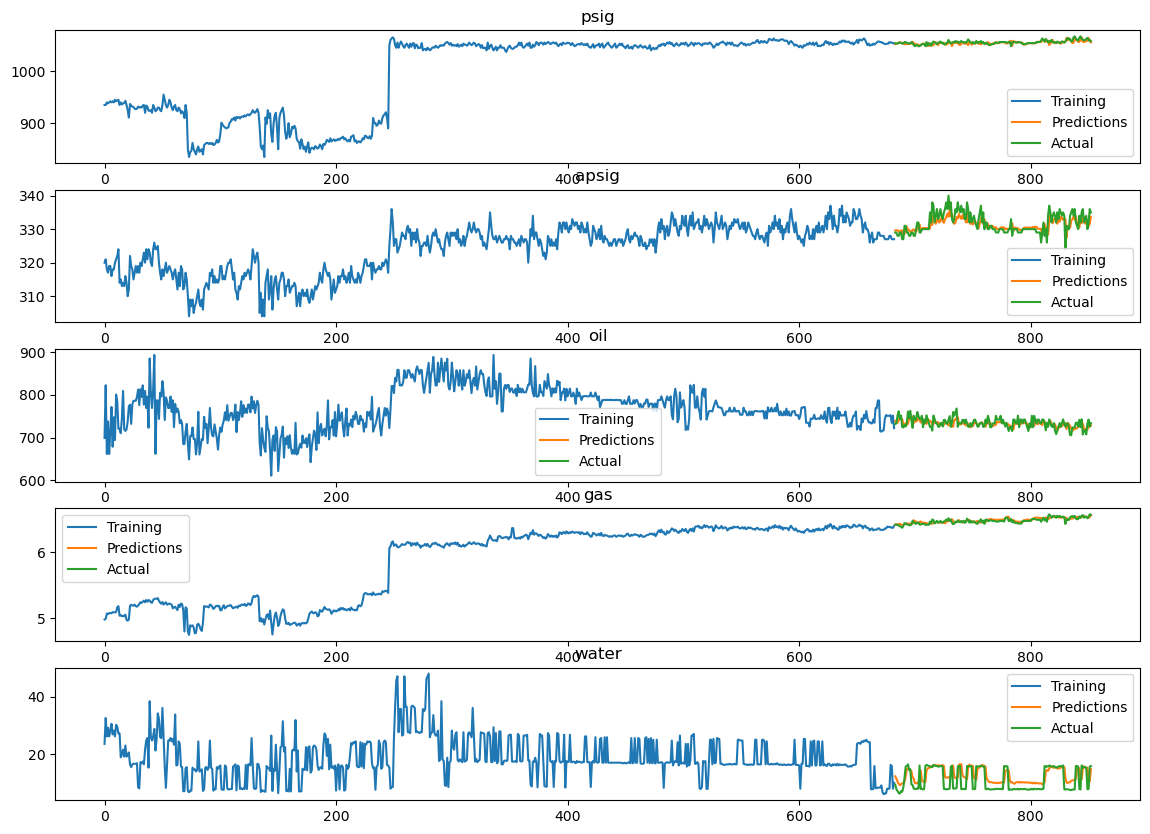

In [21]:
# create plot the predictions and actual comparison
fix, axs = plt.subplots(figsize=(14, 10), nrows=5)

for i, ax in enumerate(axs):
    ax.plot(list(range(0, train_X.shape[0])), train_X.iloc[:,i], label='Training')
    ax.plot(list(range(train_X.shape[0], train_X.shape[0] + predictions.shape[0])), predictions.iloc[:,i], label='Predictions')
    ax.plot(list(range(train_X.shape[0], train_X.shape[0] + test_y.shape[0])), test_y.iloc[:,i], label='Actual')
    ax.set_title(df_choke_38_normalized.columns[i])
    ax.legend()

plt.show()

In [ ]:
# summarize history for loss
plt.figure(figsize=(10, 6))
plt.plot(list(range(0, test_y.shape[0])), test_y[:, 0], label='Actual values') # Change train_X.shape[0] to test_y.shape[0]
plt.plot(list(range(0, predictions.shape[0])), predictions[:, 0], label='Predicted values') # Change range to match predictions length
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('LSTM Network Predictions')
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1000x600 with 0 Axes>

In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
Wf = np.random.rand(2, 1)
Wi = np.random.rand(2, 1)
Wc = np.random.rand(2, 1)
Wo = np.random.rand(2, 1)
bf = np.random.rand(1)
bi = np.random.rand(1)
bc = np.random.rand(1)
bo = np.random.rand(1)

# print
# print('Wf:', Wf)
# print('Wi:', Wi)
# print('Wc:', Wc)
# print('Wo:', Wo)
# print('bf:', bf)
# print('bi:', bi)
# print('bc:', bc)
# print('bo:', bo)

# save weights as DataFrame
df_weights = pd.DataFrame({'Wf': Wf.flatten(), 'Wi': Wi.flatten(), 'Wc': Wc.flatten(), 'Wo': Wo.flatten()})
df_biases = pd.DataFrame({'bf': bf, 'bi': bi, 'bc': bc, 'bo': bo})

# save to .csv
df_weights.to_csv('weights.csv', index=False)
df_biases.to_csv('biases.csv', index=False)

display(df_weights)
display(df_biases)

In [ ]:
cell = pd.DataFrame([], columns=['hidden state', 'cell state'])
# use function above
cell0 = simple_lstm_cell(
    train.iloc[0].values,
    0,
    0,
    Wf,
    Wi,
    Wc,
    Wo,
    bf,
    bi,
    bc,
    bo
)

# create function to simplify code above line 19 and 22
def cell_append(self, new_cell):
    new_cell = pd.DataFrame([new_cell], columns=['hidden state', 'cell state', 'output state'])
    return pd.concat([self, new_cell], ignore_index=True)
# append the first cell to the cell DataFrame
cell = cell_append(cell, cell0)

# print the updated cell DataFrame
cell

In [ ]:
train

In [ ]:
train.iloc[0]

In [ ]:
# cell 1
cell1 = simple_lstm_cell(
    train.iloc[1].values,
    cell[['hidden state']].iloc[0].values[0],
    cell[['cell state']].iloc[0].values[0],
    Wf,
    Wi,
    Wc,
    Wo,
    bf,
    bi,
    bc,
    bo
)
# cell1
# # append the second cell to the cell DataFrame
cell = cell_append(cell, cell1)
cell

In [ ]:
# what the result of that LSTM cell

#  create loop
# for i in range(2, len(train)):
#     new_cell = simple_lstm_cell(
#         train.iloc[i].values,
#         cell[['hidden state']].iloc[-1].values[0],
#         cell[['cell state']].iloc[-1].values[0],
#         Wf,
#         Wi,
#         Wc,
#         Wo,
#         bf,
#         bi,
#         bc,
#         bo
#     )
#     cell = cell_append(cell, new_cell)


In [ ]:
# create neural network from that LSTM cell
def simple_lstm(inputs, h, c, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    hidden_states = []
    cell_states = []
    output_states = []
    for i in range(len(inputs)):
        h, c, o = simple_lstm_cell(
            inputs[i],
            h,
            c,
            Wf,
            Wi,
            Wc,
            Wo,
            bf,
            bi,
            bc,
            bo
        )
        hidden_states.append(h)
        cell_states.append(c)
        output_states.append(o)
    return hidden_states, cell_states, output_states

In [ ]:
# use that function
hidden_states, cell_states, output_states = simple_lstm(
    train.values,
    0,
    0,
    Wf,
    Wi,
    Wc,
    Wo,
    bf,
    bi,
    bc,
    bo
)

In [ ]:
# predict LSTM
prediction = output_states[-1]